# **Introduction**
---

> **This computer vision tutorial will demonstrate how to use transfer learning with a pretrained convolutional neural network (CNN) in PyTorch (https://pytorch.org/) to perform multi-label classification with a custom dataset. It will also demonstrate how to finetune a pretrained CNN to create a feature extractor for a custom dataset. The feature extractor generates feature vectors for images that can be used in other machine learning algorithms, or used to calculate similarity between images. This tutorial will use widely-used data science and machine learning libraries: NumPy, pandas, scikit-learn, Matplotlib, PyTorch, Torchvision, and Pillow. I recommend installing these with pip in a virtual environment with Python 3.7 (https://docs.python.org/3.7/tutorial/venv.html):**

> `pip install numpy pandas scikit-learn matplotlib torch torchvision Pillow`

> **This tutorial will focus on practical aspects of getting a custom dataset ready for training and inference, and will not attempt to explain computer vision theory or the mathematics underlying CNNs. For a detailed overview of computer vision I recommend watching the lectures of the University of Washington course taught by Joseph Redmon (creator of the YOLO object detection algorithm) when he was a graduate student, https://www.youtube.com/playlist?list=PLjMXczUzEYcHvw5YYSU92WrY8IwhTuq7p. For a detailed overview of CNNs I recommend watching the lectures of Stanford's CS231n course, https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv. If you are interested in a mathematical understanding of neural networks, I recommend this book written by Ian Goodfellow (creator of Generative Adversarial Networks) and Yoshua Bengio (one of the founders of deep learning), https://www.deeplearningbook.org/**

In [1]:
import os
import copy
import time
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torchvision
from torchvision import transforms as T
import matplotlib.pyplot as plt
from PIL import Image

## **Table of Contents**
---
1. [Organize dataset](#1)<br>
    1.1 [Importing and cleaning data](#1p1)<br>
    1.2 [One-hot encoding labels](#1p2)<br>
    1.3 [Create train, validation, and test sets](#1p3)<br>
2. [Prepare data for CNN](#2)<br>
    2.1 [PyTorch dataset class](#2p1)<br>
    2.2 [Image Transformations](#2p2)<br>
    2.3 [Image Augmentation](#2p3)<br>
3. [Training a new multi-label clasifier with a pretrained model](#3)<br>
    3.1 [Evaluation metric: AUC](#3p1)<br>
    3.2 [Set up model and training parameters](#3p2)<br>
    3.3 [Define train, test and fit functions](#3p3)<br>
    3.4 [Evaluate trained model](#3p4)<br>
4. [Fine-tune a pretrained model](#4)<br>
5. [Model inference](#5)<br>

<a id='1'></a>
# **1. Organize Dataset**
---

> **In this tutorial I will be using a fashion dataset available on Kaggle (https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset). This dataset contains ~44K images with associated labels such as category (ex. Apparel, Accessories), article type (ex. Shirts, Jeans), usage (ex. Casual, Formal) and color. There are some errors and null values in the dataset, so I will demonstrate how to use pandas (https://pandas.pydata.org) to clean up the data and format it for input into a CNN.**

<a id='1p1'></a>
## **1.1 Importing and cleaning data**
---

> **The styles.csv file contains one row for every image in the dataset, with the columns corresponding to the image ID and 9 categorical labels for the image. This csv file can be read using the `read_csv()` function in pandas. There are some poorly formatted lines in the the csv, so setting the `error_bad_lines` parameters to `False` will skip these lines. Loading the csv in pandas creates a *dataframe*, the primary data structure used in pandas, and is similar to a spreadsheet or SQL table.**

In [62]:
# Read in .csv as pandas dataframe.
# Set error_bad_lines=False to skip incorrectly formatted rows.
# Set warn_bad_lines=False to stop printing a warning every time a line is skipped.
csv_path = 'C:/Users/matth/Documents/fashion_product_dataset/data/styles.csv'
style_df = pd.read_csv(csv_path, error_bad_lines=False, warn_bad_lines=False)
print(f'Num Rows: {len(style_df)}')

Num Rows: 44424


> **There are 44424 items in our dataset, let's see what the data looks like by using the pandas function `head()` to return the first 5 rows of the dataframe.**

In [63]:
style_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


> **Machine learning algorithms cannot handle null (empty) values, so lets check if there are any null values in the labels.**

In [64]:
style_df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

> **There are indeed null values in data. We will need to either remove these, or replace them with real values. There are relatively few null values in this dataset, so in this tutorial we will simply remove any row that contains a null value in any of its columns. pandas has a guide on how to deal with missing data (https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html), and scikit-learn has a guide on how to impute (infer from the rest of the data) missing values (https://scikit-learn.org/stable/modules/impute.html)**

In [65]:
# Inplace-drop any row (axis='index') that has at least one null value in any of it's columns (how='any')
style_df.dropna(axis='index', how='any', inplace=True)
print(f'Num Rows after dropping null: {len(style_df)}')

Num Rows after dropping null: 44077


> **347 items were removed after dropping rows with null values. This is less than 1% of the data, so simply removing these rows is likely a viable strategy for this dataset.**

<a id='1p2'></a>
## **1.2 One-hot encoding labels**
---
> **The labels in this dataset are categorical, but machine learning algorithms require labels to be numerical. One way of encoding categorial features is called one-hot encoding, where a positive instance of a label is given the value 1, otherwise its value is 0. Note that there are also other methods of encoding categorial labels (https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). The pandas function `describe()` can be used to see how many unique labels are in each of the categories (columns) of our dataset.**

In [6]:
style_df.describe(include=np.object) # use include=np.object to get categorical data, include=np.number to get numeric data

,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName
count,44077,44077,44077,44077,44077,44077,44077,44077
unique,5,7,45,142,46,4,8,30806
top,Men,Apparel,Topwear,Tshirts,Black,Summer,Casual,Lucera Women Silver Earrings
freq,22109,21366,15387,7066,9700,21440,34397,82


> **Here we can see the column masterCategory has 7 unique labels, with the top label being *apparel* with a frequency of 21366/44077 items. Let's look at the names of the unique labels in *masterCategory***

In [7]:
print(style_df.masterCategory.unique())

['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']


> **In this tutorial, we will train a CNN to predict style aspects of an item. The categories season and year will not be very useful here because they do not describe the style content of the item in the image. Similarly *productDisplayName* is too complicated to one-hot encode in its current state (note that there are 30806 unique labels), though NLP techniques could potentially be used to simplify it. We will therefore exclude these three columns from from one-hot encoding. pandas has a handy `get_dummies()` function that will one-hot encode selected columns.**

In [8]:
one_hot_categories = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'usage'] # Choose which columns to one-hot encode
one_hot_df = pd.get_dummies(style_df, columns=one_hot_categories)                                      # One-hot encode the columns
one_hot_df.drop(labels=['season', 'year', 'productDisplayName'], axis='columns', inplace=True)         # Drop columns we are not interested in using

> **Let's see what the one-hot encoded data looks like**

In [9]:
one_hot_df.head()

,id,gender_Boys,gender_Girls,gender_Men,gender_Unisex,gender_Women,masterCategory_Accessories,masterCategory_Apparel,masterCategory_Footwear,masterCategory_Free Items,...,baseColour_White,baseColour_Yellow,usage_Casual,usage_Ethnic,usage_Formal,usage_Home,usage_Party,usage_Smart Casual,usage_Sports,usage_Travel
0,15970,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,39386,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,59263,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,21379,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,53759,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


> **Now, for every unique label in each category, each item can take the value 1 or 0 depending on whether that label applies to the item. This means each label is now a 253-element one-hot encoded vector (254 columns - 1 column for the id). We can plot the sorted distribution of positive label instances to see how balanced the labels are.**

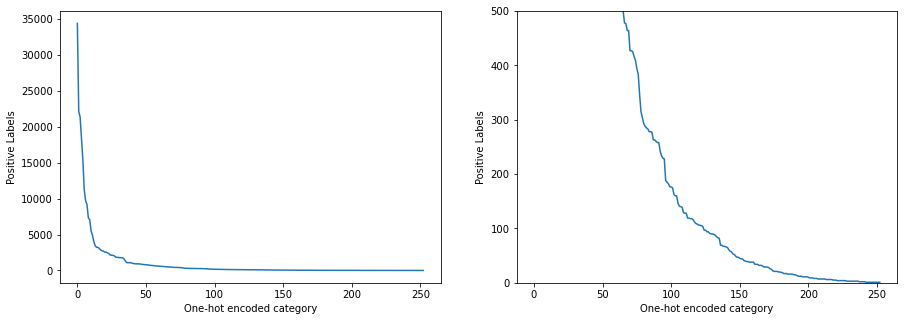

In [10]:
# Labels are one-hot encoded, so we can get the total number of positive instances of each label by summing the columns of the dataframe. The first column is image ID, so it will be excluded.
num_positive_instances = one_hot_df.sum()[1:]

# Plot the full distribution (left), and a zoomed-in view (right; y-axis max set to 500)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(sorted(num_positive_instances, reverse=True))
ax[1].plot(sorted(num_positive_instances, reverse=True))
ax[1].set_ylim([0, 500])
for i in range(0, 2):
    ax[i].set_ylabel('Positive Labels')
    ax[i].set_xlabel('One-hot encoded category')
plt.show()

> **Looking at the plot on the left, we can see that this dataset is imbalanced: there is a skewed distribution of positive labels. This makes sense because the original dataset was organized in a hierarchical manner: there are few possible master categories (7), and many possible article types (142). Looking at the zoomed-in plot on the right, we can see that many categories in this dataset have very few positive instances, so using these categories as labels in machine learning algorithms will likely give poor results. Let's find and remove any category with fewer than 100 instances.**

In [11]:
min_num_entries_per_category = 100
too_few_categories = [col for col, val in one_hot_df.sum().iteritems() if val < min_num_entries_per_category]
print(f'Categories with fewer than {min_num_entries_per_category} entries:\n\n {", ".join(too_few_categories)}')

Categories with fewer than 100 entries:

 masterCategory_Home, masterCategory_Sporting Goods, subCategory_Bath and Body, subCategory_Beauty Accessories, subCategory_Eyes, subCategory_Gloves, subCategory_Hair, subCategory_Home Furnishing, subCategory_Mufflers, subCategory_Perfumes, subCategory_Shoe Accessories, subCategory_Skin, subCategory_Skin Care, subCategory_Sports Accessories, subCategory_Sports Equipment, subCategory_Stoles, subCategory_Umbrellas, subCategory_Vouchers, subCategory_Water Bottle, subCategory_Wristbands, articleType_Accessory Gift Set, articleType_Baby Dolls, articleType_Bangle, articleType_Basketballs, articleType_Bath Robe, articleType_Beauty Accessory, articleType_Blazers, articleType_Body Lotion, articleType_Body Wash and Scrub, articleType_Booties, articleType_Boxers, articleType_Bracelet, articleType_Camisoles, articleType_Churidar, articleType_Clothing Set, articleType_Compact, articleType_Concealer, articleType_Cushion Covers, articleType_Duffel Bag, article

> **Now drop these columns**

In [12]:
one_hot_df.drop(too_few_categories, axis='columns', inplace=True)
print(f'Num categories: {len(one_hot_df.columns)-1}')

categories = one_hot_df.columns[1:]

Num categories: 124


> **Dropping these columns removed 130 categories, leaving our dataframe columns as the image ID and 123 possible labels that we would like a classifier to predict.**

<a id='1p3'></a>
## **1.3 Create train, validation, and test sets**
---
> **Before we start training a model, we need to separate our data into train, validation, and test sets. First, 20% of our original dataset will be allocated to the test set, which will be used for final model evaluation. Of the remaining 80% of the data, 15% will be allocated to a validation set, which will be used during training to check for model overfitting. A more sophisticated approach would be to use cross-validation to separate the remaining 80% of the data into multiple train-val sets. It is important to *never touch the test set* until you report final model metrics. Here, we will simply randomly separate the data using scikit-learn's `train_test_split()` function. There are more sophisticated methods of separating data such as stratified sampling, where the relative frequecies of labels is kept equal between train/val/test sets (often a good idea when dealing with imbalanced data). You can read more about cross-validation and sampling methods at (https://scikit-learn.org/stable/modules/cross_validation.html)**

In [13]:
# Convert pandas dataframe data to numpy datatypes
X = one_hot_df['id'].to_numpy()                     # X is the image ID (the first column in the dataframe)
y = one_hot_df[one_hot_df.columns[1:]].to_numpy()   # y is the one-hot encoded label vector (all but the first column in the dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)               # Create train and test sets from entire dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=45)    # Create train and val sets from train set. Here is where you could also do k-fold cross validation.

print(f'X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}, Total: {len(X_train)+len(X_val)+len(X_test)}')
print(f'y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}, Total: {len(y_train)+len(y_val)+len(y_test)}')

X_train: 29971, X_val: 5290, X_test: 8816, Total: 44077
y_train: 29971, y_val: 5290, y_test: 8816, Total: 44077


> **Overall, 68% of the data is in the train set, 12% in the validation set, and 20% in the test set. It is now a good idea to save these splits.**

In [13]:
np.savez('fashion_data_splits.npz',
         X_train=X_train, y_train=y_train,
         X_val=X_val,     y_val=y_val,
         X_test=X_test,   y_test=y_test,
         categories=categories)

> **In the future, we can load the data using:**

In [14]:
data_path = 'C:/Users/matth/Documents/fashion_product_dataset/fashion_data_splits.npz'
data_splits = np.load(data_path, allow_pickle=True)
X_train     = data_splits['X_train']
y_train     = data_splits['y_train']
X_val       = data_splits['X_val']
y_val       = data_splits['y_val']
X_test      = data_splits['X_test']
y_test      = data_splits['y_test']
categories  = data_splits['categories']

In [66]:
X_train

array([ 7595, 41231, 39309, ..., 52090,  7793, 10128], dtype=int64)

<a id='2'></a>
# **2. Prepare Data for CNN**
---
> **We now have three sets of (X, y) data, where X is a list of image IDs, and y is an array of one-hot encoded vectors. To train the CNN, we need to load and preprocess the images corresponding to the image IDs in X, pass the images through the CNN, and compare the CNN output to the labels in y. PyTorch requires data to be formatted in a special Tensor datatype, and images must be in formatted in rank-4 tensor (4 axes/dimensions) corresponding to: [batchsize, channels, height, width]. Fortunately, PyTorch comes with functions to make these data transformations easier.**

<a id='2p1'></a>
## **2.1 PyTorch Dataset Class**
---
> **PyTorch uses Dataset and DataLoader classes to help organize the flow of data into a neural network. For a custom dataset, you must write a class that inherits Dataset and overrides three functions: `__init__`, `__len__`, and `__getitem__`. Here, we will create a FashionDataset class that stores and returns the image paths and labels for any (X, y) set of data. Our X data only has image IDs, so we also provide the FashionDataset class a directory where the JPEG-formatted images are saved. We can also provide an optional transform function that will be discussed latter when we reshape, normalize, and potentially augment images. PyTorch has a nice tutorial about writing custom dataset classes https://pytorch.org/tutorials/beginner/data_loading_tutorial.html**

In [15]:
img_dir = 'C:/Users/matth/Documents/fashion_product_dataset/data/images/'  # Define the directory where images are stored

In [16]:
class FashionDataset(torch.utils.data.Dataset):                # Define our new class that inherits torch.utils.data.Dataset
    def __init__(self, X, y, data_dir, transform=None):        # Creating our class requires we give it X (image ids), y (labels), data_dir (where our images are),
                                                               #   and a transform function that resizes, normalizes, and potentially augments images (optional, so it defaults to None)
            
        self.img_paths = []                                    # Define an empty list where we will store the image paths corresponding to the IDs in X
        self.labels = []                                       # Define an empty list where we will store the labels in y
        self.transform = transform                             # Define the optional transform
        
        for img_id, label in zip(X, y):                        # Loop through both X and y
            img_path = os.path.join(data_dir, f'{img_id}.jpg') # The image path is the image ID with a '.jpg' extension in the data_dir directory
            if os.path.exists(img_path):                       # Make sure the image path actually exists first
                self.img_paths.append(img_path)                # Add the image path to the self.img_paths list
                label = torch.from_numpy(label)                # Convert the label in numpy format to the PyTorch Tensor format
                self.labels.append(label)                      # Add the label to the self.labels list
                
    def __len__(self):
        return len(self.img_paths)                             # Return the number of images in self.img_paths
    
    def __getitem__(self, i):
        img_path = self.img_paths[i]                           # Get the image path at index i from self.img_paths
        img = Image.open(img_path)                             # Open the image path with Pillow
        
        if self.transform:                                     # If a transformation function was provided,
            img = self.transform(img)                          #   Apply a transformation to the image
            
        label = self.labels[i]                                 # Get the label at index i from self.labels
        return img, label.float()                              # Return the img, and the label in floating point format

> **An instance of our FashionDataset class is defined by passing in X, y, data_dir, and (optionally) transform. Instances of our FashionDataset class can be indexed like a list to call the function we defined in __getitem__. Here, we create an instance called `train_dataset` that returns the image and one-hot encoded label for each item in the training set.**

One-hot Label:
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

Categorical Labels:
['gender_Women', 'masterCategory_Footwear', 'subCategory_Shoes', 'articleType_Sports Shoes', 'baseColour_Blue', 'usage_Sports']

Img Size:
(1800, 2400)



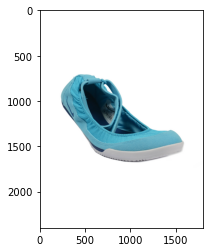

In [67]:
train_dataset = FashionDataset(X=X_train, y=y_train, data_dir=img_dir)   # Instantiate a training dataset with X,y training data and the img_dir defined above

img, label = train_dataset[0]                                            # Accessing an index of the train_dataset instance of FashionDataset calls __getitem__, which returns an image and label
print(f'One-hot Label:\n{label}\n')
categorical_labels = [col for one_hot, col in zip(label, categories) if one_hot == 1]  # Get the names of the categories represented by 1 in the one-hot encoded label
print(f'Categorical Labels:\n{categorical_labels}\n')
print(f'Img Size:\n{img.size}\n')
plt.imshow(img);

> **We can see that the first index of `train_dataset` returns an 1800x2400 pixel image of a shoe and a one-hot encoded vector corresponding to the categories 'gender_Women', 'masterCategory_Footwear', 'subCategory_Shoes', 'articleType_Sports Shoes', 'baseColour_Blue', 'usage_Sports'. However, this image is not yet ready to be used in a CNN, first it must be resized, normalized, and converted to a PyTorch Tensor datatype. We can do this by passing an appropriate transformation function to `transform` when we instantiate the class.**

<a id='2p2'></a>
## **2.2 Image Transformations**
---
> **Torchvision is a library associated with PyTorch to provide useful functions for dealing with image data, including transforms that prepare images for a CNN. `simple_transform` here is defined as a composition of functions that resize, center crop, and convert an image to a Tensor. Note that in this tutorial the `torchvision.transforms` library has been import as `'T'`, and the transforms used in this tutorial only work on images in Pillow format (remember when we created the FashionDataset class we opened the images using the Pillow library in the `__getitem__` function).**

> **WARNING: The `ToTensor()` transform not only converts an image to a PyTorch Tensor, but also scales the pixel values to floating point values between 0 and 1. Images in this dataset are RGB-formatted (the most common image format), with pixel values between 0 and 255 encoded as an unsigned 8-bit integer. `ToTensor()` converts pixel data to floating point numbers, divides by 255, and converts to Tensor. Scaling is a very important step in preprocessing images for a CNN, so in other tutorials and blog posts you may see steps where pixel values are explicitly divided by 255. `ToTensor()` already does this, so do not divide by 255 again after applying this transformation.**

torch.Size([3, 224, 224])
Img Mean: 0.86
Img Std: 0.26


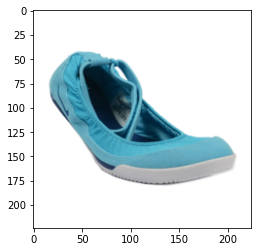

In [18]:
simple_transform = T.Compose([         # Compose a sequential list of functions
    T.Resize(256),                     # Resize an image while maintaining aspect ratio such that the smaller edge of the image is matched to 256 pixels
    T.CenterCrop(224),                 # Crop the image at the center such the the resulting image is a square with all sides matched to 224 pixels
    T.ToTensor()                       # Convert the image to a Tensor and scale the pixel values to between 0 and 1.
])

train_dataset = FashionDataset(X=X_train, y=y_train, data_dir=img_dir, transform=simple_transform)  # This time provide the simple_transform function

img, label = train_dataset[0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0));       # PyTorch places the channel dimension of an image at the beginning, but matplotlib assumes the channel dimension is last,
                                        #   so we must move the channel dimension with the permute() function in order to display the image with matplotlib.

print(f'Img Mean: {img.mean():.2f}')    # Calculate the mean of the pixel values in the image
print(f'Img Std: {img.std():.2f}')      # Calculate the standard deviation of the pixel values in the image

> **After providing the transformation function, the image is now a 3x224x224 tensor, and is almost ready to be used in a CNN. The pretrained CNN we will use in this tutorial (ResNet-18), assumes that input images have been normalized such that the mean of the pixel values is 0 with a standard deviation of 1 (across the entire dataset). We can see above that the mean pixel value in this image is 0.86 with a standard deviation of .26, so using this unnormalized images will not give optimal results on the pretrained model. Therefore, we will calculate the mean and standard deviation of the pixel values of all the images in our dataset.**

> **Note: the pretrained model we will use was trained on ImageNet, a dataset of over 14 million images. ImageNet has channel-wise mean pixel values of [0.485, 0.456, 0.406] with standard deviation [0.229, 0.224, 0.225]. It takes a long time to calculate the channel-wise mean and standard deviation of a dataset, so I have precomputed it for our fashion dataset used here: mean = [0.7969, 0.7716, 0.7642], std = [0.2562, 0.2739, 0.2792]. We can see that the mean pixel values are very different between ImageNet and out dataset. This is because the images in our dataset have backgrounds consisting of entirely white pixels (which have a value of 1), while ImageNet consists of natural images. Thus, it is very important to normalize our dataset because the distribution of pixel intensities is different than the datset that the pretrained model was trained on.**

In [ ]:
# This takes a long time to run. For this dataset, the mean and std of the training set is:
#   mean = [0.7969, 0.7716, 0.7642]
#   std = [0.2562, 0.2739, 0.2792]

mean = 0.
std = 0.
for img, label in train_dataset:
    mean += img.mean([1,2])
    std += img.std([1,2])
mean /= len(train_dataset)
std /= len(train_dataset)

print(f'Mean: {mean}')
print(f'Std: {std}')

> **Now that we know the channel-wise mean and standard deviation of the images in our dataset, we can add a normalization transform to our `simple_transform` function.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Img Mean: 0.29
Img Std: 1.00


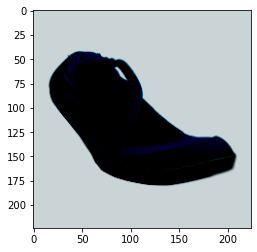

In [68]:
simple_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.7969, 0.7716, 0.7642],   # Normalize an image with channel-wise means
                std=[0.2562, 0.2739, 0.2792])    #   and standard deviations
])

train_dataset = FashionDataset(X_train, y_train, data_dir=img_dir, transform=simple_transform)

img, label = train_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print(f'Img Mean: {img.mean():.2f}')
print(f'Img Std: {img.std():.2f}')

> **Now the mean pixel value of our image is 0.29 with a standard deviation of 1. Note that the image does not appear normal when displayed in matplotlib because normalization makes some pixel values negative. Negative values are automatically clipped to 0 in matplotlib (as indicated by the warning message).**

<a id='2p3'></a>
## **2.3 Image Augmentation**
---
> **When training a CNN, it is often very useful to apply Image Augmentation to the training set. The purpose of augmentation is to change the image appearence without changing the content (and thus the labels). This increases the diversity in training images passed through the model without having to obtain and label more data. Some common image augmentations are: flipping across the vertical or horizontal axis, rotation, translation, scaling, and random cropping. Augmentations are usually randomized, so that passing the same image through an augmenting transform multiple times produces different images. When training a CNN, it is common to apply image augmentation to the training set, but not the test set. Here we will define two transformations, `train_transform` with augmentation, and `test_transform` without augmentation. We will then create three FashionDataset instances, `train_dataset`, `val_dataset`, and `test_dataset`.**

In [74]:
train_transform = T.Compose([
    T.Resize(256),
    T.RandomVerticalFlip(),                                                                     # Flip the image vertically
    T.RandomHorizontalFlip(),                                                                   # Flip the image horizontally
    T.RandomAffine(degrees=90, translate=(.2, .2), scale=(.5, 1.5), fillcolor=(255,255,255)),   # Apply random affine transformation consisting of rotation, translation, scaling (zoom in/out).
                                                                                                #   fillcolor=(255,255,255) means new pixels resulting from rotation, translation, or scaling
                                                                                                #   are replaced by white pixels (because the background of all of the images in our dataset is white).
    T.RandomCrop(224),                                                                          # Randomly crop a square with sides of length 224 pixels
    T.ToTensor(),
    T.Normalize(mean=[0.7969, 0.7716, 0.7642],
                std=[0.2562, 0.2739, 0.2792])
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.7969, 0.7716, 0.7642],
                std=[0.2562, 0.2739, 0.2792])
])

train_dataset = FashionDataset(X_train, y_train, data_dir=img_dir, transform=train_transform)
val_dataset = FashionDataset(X_val, y_val, data_dir=img_dir, transform=test_transform)
test_dataset = FashionDataset(X_test, y_test, data_dir=img_dir, transform=test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Categorical Labels: ['gender_Women', 'masterCategory_Footwear', 'subCategory_Shoes', 'articleType_Sports Shoes', 'baseColour_Blue', 'usage_Sports']


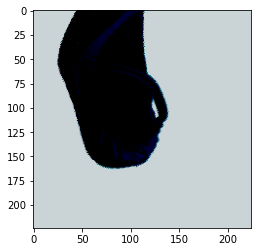

In [79]:
img, label = train_dataset[0]
categorical_labels = [col for one_hot, col in zip(label, categories) if one_hot == 1]
print(f'Categorical Labels: {categorical_labels}')
plt.imshow(img.permute(1, 2, 0));

> **Each time the same item is selected from `train_dataset`, the image appears different, but the label is the same.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Categorical Labels: ['gender_Women', 'masterCategory_Accessories', 'subCategory_Eyewear', 'articleType_Sunglasses', 'baseColour_Brown', 'usage_Casual']


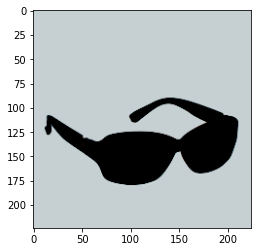

In [82]:
img, label = val_dataset[0]
categorical_labels = [col for one_hot, col in zip(label, categories) if one_hot == 1]
print(f'Categorical Labels: {categorical_labels}')
plt.imshow(img.permute(1, 2, 0));

> **Each time the same item is selected from `val_dataset`, the image and label are the same.**

<a id='3'></a>
# **3. Training a New Multi-label Classifier with a Pretrained Model**
---
> **Now that we have created train/val/test datasets, we are ready to start training a new multilabel classifier using a pretrained ResNet-18 model as a fixed feature extractor. However, before we set up model training, first we should define the metric we'll use to evaluate our model.**

<a id='3p1'></a>
## **3.1 Evaluation metric: AUC**
---
> **For multilabel classification, one commonly used metric for evaluation is Area Under the Reciever Operator Characteristic Curve (ROC-AUC, or simply AUC). Using the `roc_auc_score` function in scikit-learn, we can see in the following code that a random classifier will have an AUC of 0.5, while a perfect classifier will have an AUC of 1. More details can be found at https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics**

In [28]:
# An AUC score corresponding to a random choice is 0.5
print(f'Random AUC: {roc_auc_score(y_val, np.random.random_sample(y_val.shape), average="samples"):.4f}')

# A perfect AUC score is 1
print(f'Perfect AUC: {roc_auc_score(y_val, y_val, average="samples"):.4f}')

Random AUC: 0.5007
Perfect AUC: 1.0000


<a id='3p2'></a>
## **3.2 Set up Model and Training Parameters**
---
> **To train a neural network, we need 1) a model architecture, 2) optimizer, 3) loss function, and 3) data. We also need to set 3 parameters: number of epochs, learning rate, and batchsize. I have included an optional parameter called `num_workers` that defines how many CPU threads should be used for loading data to the GPU (more = faster).**

> **1. The model architecture we will use here is ResNet-18, a relatively simply CNN with 18 layers and skip connections. A pretrained model can be easily loaded in PyTorch using the `torchvision.models` library and setting `pretrained=True`. Many other easily imported pretrained models are available at https://pytorch.org/docs/stable/torchvision/models.html. If you are interested in a large state-of-the-art model, I recommend `torchvision.models.resnext101_32x8d()`. For a fast, compact model I recommend `torchvision.models.mobilenet_v2()`.**

> **2. The optimizer we will use here is Adam, which has fine performance without tuning learning rate parameters. There are many other optimizers available at https://pytorch.org/docs/stable/optim.html#algorithms, but I recommend starting off with Adam using a learning rate of 0.001.**

> **3. The loss function we will use is Binary Cross Entropy. Here we are doing multilabel classification with 124 categories, so using Binary Cross Entropy as our loss function makes our problem similar to doing 124 simultaneous binary classifications (note that this is not the only way, or necessarily the best way, to do multilabel classification). The actual implementation we will use in PyTorch is `BCEWithLogitsLoss()`, which is a more numerically stable version of the loss function that incorporates a sigmoid function. Since this loss function includes a sigmoid function, we will not explicitly put our model outputs through a sigmoid layer before calculating loss. When we are making predictions later, however, we will need to apply a sigmoid function to the model output. Details of the loss function can be found at https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss**

> **4. We have already defined our dataset classes. However, indexing our datasets returns a single image with dimensions [channels, height, width], while CNNs in PyTorch require batched input with dimenions [batchsize, channels, height, width]. PyTorch includes the DataLoader class that simply takes in a dataset and batchsize, and returns an iterator that returns images and labels in the required format. The DataLoader class also includes helpful options for shuffling the data and multiprocessing so that multiple CPU cores can load different iamges simultaneously to speed up training.**

In [30]:
num_epochs = 50
learning_rate = 0.001
batchsize = 256
num_workers = 16                                                         # Number of CPU cores to use when loading data. Using more cores will load data faster.
                                                                         #   If you are unsure, set to 0 (single-core, main process)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Define the computing device for training the model. Options are 'cpu' (very slow),
                                                                         #   or 'cuda' if you have an NVIDIA gpu with CUDA drivers installed

model = torchvision.models.resnet18(pretrained=True)                     # Load a ResNet-18 model pretrained on ImageNet
for param in model.parameters():                                         # Loop through all of the parameters (weights) of the model
    param.requires_grad = False                                          # Freeze the weights of the parameters (stop gradients from being tracked)
num_ftrs = model.fc.in_features                                          # Get the number of features from the second-to-last layer of the network (before the classifier)
model.fc = torch.nn.Linear(num_ftrs, len(categories))                    # Create a new classifier layer (fully-connected layer) with the number of categories we want to predict
model = model.to(device)                                                 # Send the model to the computing device

criterion = torch.nn.BCEWithLogitsLoss()                                 # Define the criterion (loss function). Here we will use Binary Cross Entropy with Logits
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)    # Define the optimizer with model parameters and learning rate.
                                                                         #   Here we will use Adam optimizer on our newly-created fully-connect layer only.

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers)   # Create train and val dataloaders that handle batchsize,
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers)       #   shuffling the dataset each epoch, and multicore processing.

<a id='3p3'></a>
## **3.3 Define train, test, and fit functions**
---
> **Unlike another popular neural network library, Keras, in PyTorch we must define our own training functions. This means we must write more repetative boiler-plate code (most train functions are very similar), but it also gives us more freedom to easily change the training process. Here I have written three functions to help train a CNN: train, test and fit. The train function trains a CNN for one epoch. The test function evaluates a CNN without changing the weights of the model. The fit function applies train and test functions over a set number of epochs, keeps a log of training progress, and saves train and val losses and AUC scores while training so they can be plotted later.**

In [31]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()                                                  # Set model parameters to training mode
    running_loss = 0.0                                             # Keep track of running loss so average loss can be calculated at the end of the epoch
    all_true = []                                                  # Keep track of all of the true and predicted labels
    all_pred = []                                                  #   so AUC score can be calculated at the end of the epoch
    
    for i, (imgs, labels) in enumerate(dataloader):                # Loop through all batches in the dataloader
        
        all_true += labels.tolist()                                # Save true labels
        imgs = imgs.to(device)                                     # Send images and labels to computing device. If the model is on 'cuda',
        labels = labels.to(device)                                 #   the images and labels must also be on cuda
        
        optimizer.zero_grad()                                      # Zero the gradients so the optimizer can keep track of a new pass of data through the network
        pred = model(imgs)                                         # Pass a batch of images through the model
        loss = criterion(pred, labels)                             # Calculate the loss between the ground truth labels and the model predictions
        loss.backward()                                            # Perform backpropagation on the loss to train the network
        optimizer.step()                                           # Step the optimizer forward
        
        all_pred += torch.sigmoid(pred).tolist()                   # Keep track of model predictions to calculate AUC later.
                                                                   #   When we want to make predictions with our model without calculating BCEWithLogitsLoss,
                                                                   #   we must manually apply the sigmoid function to the model output to get predicted values
                                                                   #   between 0 and 1. tolist() simply converts the result to a normal Python list.
        
        running_loss += loss.item()
    return running_loss / (i+1), roc_auc_score(all_true, all_pred, average='weighted')    # Return the average loss over the epoch and the AUC score

> **The test function is almost exactly the same as the train function, except that 1) the model is placed in `eval()` mode rather than `train()` mode, and 2) the optimizer is not used and gradients through the model are not tracked because backpropagation is not being performed.**

In [32]:
def test(model, dataloader, criterion, device):
    model.eval()                                                   # Set model parameters to evaluation mode
    running_loss = 0.0
    all_true = []
    all_pred = []
    for i, (imgs, labels) in enumerate(dataloader):
        all_true += labels.tolist()
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():                                      # Don't track gradients through the model
            pred = model(imgs)
            loss = criterion(pred, labels)
            all_pred += torch.sigmoid(pred).tolist()
        
        running_loss += loss.item()
    return running_loss / (i+1), roc_auc_score(all_true, all_pred, average='weighted')

> **At it's core, the fit function simply calls train and test over a number of epochs. The rest of the code logs losses and AUC scores, and saves the best performing model.**

In [33]:
def fit(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs):
    # Log start time
    start_time = str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
    msg = f'Start model training {start_time}'
    with open('log.txt', 'a') as f: f.write(msg+'\n')
    print(msg)
    
    # Initialize best model weights, AUC score, and keep track of train/val loss and AUC
    best_model_wts = copy.deepcopy(model.state_dict())
    best_model_name = ''
    best_score = -1
    track_values = {'train_loss': [],
                    'val_loss': [],
                    'train_auc': [],
                    'val_auc': []}

    # Calculate initial loss and score on train and validation sets
    start = time.time()
    train_loss, train_score = test(model, train_dataloader, criterion, device)
    val_loss, val_score = test(model, val_dataloader, criterion, device)
    
    # Store initial losses and AUC scores
    track_values['train_loss'].append(train_loss)
    track_values['val_loss'].append(val_loss)
    track_values['train_auc'].append(train_score)
    track_values['val_auc'].append(val_score)
    
    # Print training status and write to a log file
    msg = f'Epoch 0/{num_epochs} Train Loss: {train_loss:.4f}, Train AUC: {train_score:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_score:.4f} Time: {time.time()-start:.2f}s'
    with open('log.txt', 'a') as f: f.write(msg+'\n')
    print(msg)

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        start = time.time() # Start timer to keep track of how long an epoch takes

        # Run train and test functions on train and val sets
        train_loss, train_score = train(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_score = test(model, val_dataloader, criterion, device)
        
        # Store losses and AUC scores
        track_values['train_loss'].append(train_loss)
        track_values['val_loss'].append(val_loss)
        track_values['train_auc'].append(train_score)
        track_values['val_auc'].append(val_score)

        # Save the model weights if the AUC score on the validation set is higher than the previous best model
        if val_score > best_score:
            best_score = val_score
            best_model_wts = copy.deepcopy(model.state_dict())
            if os.path.exists(best_model_name): os.remove(best_model_name)
            best_model_name = f'./best_model_weights_epoch_{epoch+1}_auc_{val_score:.4f}.pt'
            torch.save(model.state_dict(), best_model_name)

        # Print training status and write to a log file
        msg = f'Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train AUC: {train_score:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_score:.4f} Time: {time.time()-start:.2f}s'
        with open('log.txt', 'a') as f: f.write(msg+'\n')
        print(msg)
    
    return track_values

> **Now we can train the model. The fit function returns train and val losses and AUC scores every epoch so we can later plot the training performance over time. This step can take a long time (or a *very* long time on CPU).**

In [50]:
track_values = fit(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs)

Start model training 2020-05-31-11-16-51
Epoch 0/50 Train Loss: 0.7438, Train AUC: 0.5186, Val Loss: 0.7494, Val AUC: 0.5349 Time: 121.98s
Epoch 1/50 Train Loss: 0.1286, Train AUC: 0.7417, Val Loss: 0.0904, Val AUC: 0.8691 Time: 122.73s
Epoch 2/50 Train Loss: 0.0877, Train AUC: 0.8667, Val Loss: 0.0774, Val AUC: 0.9020 Time: 122.67s
Epoch 3/50 Train Loss: 0.0788, Train AUC: 0.8896, Val Loss: 0.0713, Val AUC: 0.9126 Time: 122.17s
Epoch 4/50 Train Loss: 0.0743, Train AUC: 0.8981, Val Loss: 0.0681, Val AUC: 0.9178 Time: 122.76s
Epoch 5/50 Train Loss: 0.0713, Train AUC: 0.9045, Val Loss: 0.0656, Val AUC: 0.9215 Time: 122.47s
Epoch 6/50 Train Loss: 0.0688, Train AUC: 0.9090, Val Loss: 0.0644, Val AUC: 0.9235 Time: 123.69s
Epoch 7/50 Train Loss: 0.0676, Train AUC: 0.9108, Val Loss: 0.0631, Val AUC: 0.9252 Time: 122.84s
Epoch 8/50 Train Loss: 0.0662, Train AUC: 0.9131, Val Loss: 0.0624, Val AUC: 0.9276 Time: 122.42s
Epoch 9/50 Train Loss: 0.0654, Train AUC: 0.9144, Val Loss: 0.0608, Val AUC: 

> **We can plot training progress using the values saved in `track_values`**

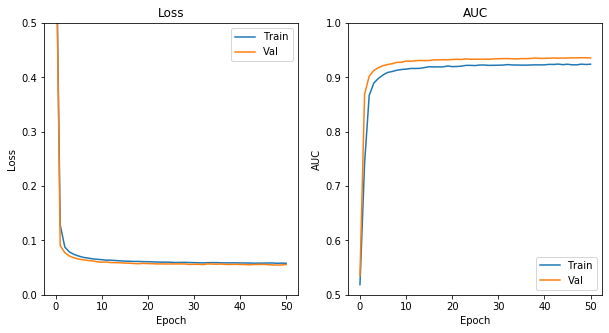

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(track_values['train_loss'], label='Train')
ax[0].plot(track_values['val_loss'], label='Val')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, .5])
ax[0].set_title('Loss')

ax[1].plot(track_values['train_auc'], label='Train')
ax[1].plot(track_values['val_auc'], label='Val')
ax[1].set_ylabel('AUC')
ax[1].set_ylim([.5, 1])
ax[1].set_title('AUC')

for i in range(0, 2):
    ax[i].legend()
    ax[i].set_xlabel('Epoch')

> **Looking at the training log, the model that did best on the validation set was the model saved at Epoch 48. Let's load this model and summarize it's performance on the train/val/test sets.**

<a id='3p4'></a>
## **3.4 Evaluate Trained Model**
---
> **Let's summarize the results on the train/val/test sets:**

In [77]:
weights_path = 'C:/Users/matth/Documents/fashion_product_dataset/best_model_weights_epoch_48_auc_0.9361_classifier_only.pt'
weights = torch.load(weights_path, map_location=lambda storage, loc:storage)
model.load_state_dict(weights)

train_loss, train_auc = test(model, train_dataloader, criterion, device)
print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')

val_loss, val_auc = test(model, val_dataloader, criterion, device)
print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, num_workers=16)
test_loss, test_auc = test(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}')

Train Loss: 0.0575, Train AUC: 0.9266
Val Loss: 0.0547, Val AUC: 0.9361
Test Loss: 0.0540, Test AUC: 0.9362


|       | **Loss**  | **AUC**   |
|-------|-------|-------|
| **Train** | .0575 | .9266 |
| **Val**   | .0547 | .9361 |
| **Test**  | .0540 | .9362 |

> **Looking at the results table it is clear that the model is not overfitting on the training set, and we are getting equivalent performance on the validation and test sets.**

<a id='4'></a>
# **4. Fine-tune a Pretrained Model**
---
> **In section 3 we kept the weights of the pretrained feature extractor frozen, and only trained the weights of a new fully-connected layer for classification. Now that we have trained the classifier layer, we can unfreeze all of the model weights and train again with a lower learning rate. This process is called fine-tuning. You can see from the code before that the only differences in training this time are: 1) we are using a lower learning rate (.0001 instead of .001), 2) we are not setting `param.requires_grad = False` to the pretrained model, and 3) we are loading our best model that we just trained so that we start of with our trained fully-connected layer.**

In [79]:
num_epochs = 50
learning_rate = 0.0001
batchsize = 256
num_workers = 16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(categories))

weights_path = 'C:/Users/matth/Documents/fashion_product_dataset/best_model_weights_epoch_48_auc_0.9361_classifier_only.pt'
weights = torch.load(weights_path, map_location=lambda storage, loc:storage)
model.load_state_dict(weights)

model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers)

track_values = fit(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs)

Start model training 2020-05-31-13-34-46
Epoch 0/50 Train Loss: 0.0576, Train AUC: 0.9268, Val Loss: 0.0547, Val AUC: 0.9361 Time: 123.50s
Epoch 1/50 Train Loss: 0.0501, Train AUC: 0.9439, Val Loss: 0.0441, Val AUC: 0.9593 Time: 126.14s
Epoch 2/50 Train Loss: 0.0428, Train AUC: 0.9598, Val Loss: 0.0391, Val AUC: 0.9677 Time: 125.40s
Epoch 3/50 Train Loss: 0.0396, Train AUC: 0.9654, Val Loss: 0.0372, Val AUC: 0.9701 Time: 126.17s
Epoch 4/50 Train Loss: 0.0375, Train AUC: 0.9693, Val Loss: 0.0362, Val AUC: 0.9720 Time: 126.11s
Epoch 5/50 Train Loss: 0.0357, Train AUC: 0.9723, Val Loss: 0.0364, Val AUC: 0.9731 Time: 126.45s
Epoch 6/50 Train Loss: 0.0346, Train AUC: 0.9738, Val Loss: 0.0353, Val AUC: 0.9748 Time: 126.87s
Epoch 7/50 Train Loss: 0.0335, Train AUC: 0.9756, Val Loss: 0.0336, Val AUC: 0.9768 Time: 126.72s
Epoch 8/50 Train Loss: 0.0322, Train AUC: 0.9771, Val Loss: 0.0326, Val AUC: 0.9779 Time: 125.93s
Epoch 9/50 Train Loss: 0.0313, Train AUC: 0.9785, Val Loss: 0.0333, Val AUC: 

> **Plot training progress:**

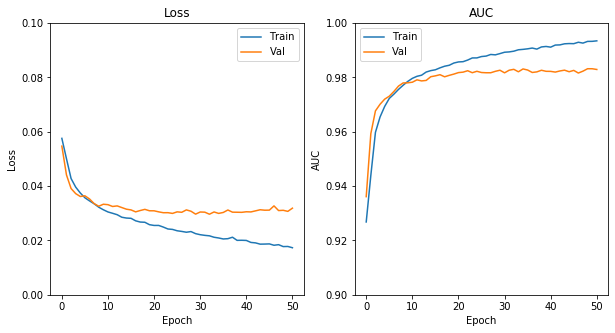

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(track_values['train_loss'], label='Train')
ax[0].plot(track_values['val_loss'], label='Val')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, .1])
ax[0].set_title('Loss')

ax[1].plot(track_values['train_auc'], label='Train')
ax[1].plot(track_values['val_auc'], label='Val')
ax[1].set_ylabel('AUC')
ax[1].set_ylim([.9, 1])
ax[1].set_title('AUC')

for i in range(0, 2):
    ax[i].legend()
    ax[i].set_xlabel('Epoch')

> **Summarize finetuning results on train/val/test sets:**

In [84]:
weights_path = 'C:/Users/matth/Documents/fashion_product_dataset/best_model_weights_epoch_48_auc_0.9832_finetuning.pt'
weights = torch.load(weights_path, map_location=lambda storage, loc:storage)
model.load_state_dict(weights)

train_loss, train_auc = test(model, train_dataloader, criterion, device)
print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')

val_loss, val_auc = test(model, val_dataloader, criterion, device)
print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, num_workers=16)
test_loss, test_auc = test(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}')

Train Loss: 0.0167, Train AUC: 0.9941
Val Loss: 0.0311, Val AUC: 0.9832
Test Loss: 0.0308, Test AUC: 0.9836


|       | **Loss**  | **AUC**   |
|-------|-------|-------|
| **Train** | .0167 | .9941 |
| **Val**   | .0311 | .9832 |
| **Test**  | .0308 | .9836 |

> **Now the model has begun overfitting, the train loss is lower than that of the val or test loss, and the train AUC is higher than that of the val or test AUC. However we have still trained a very good classifer, and finetuning has increased our final AUC score by an addition .05 relative to training the classifier layer alone.**

<a id='5'></a>
## **5. Model Inference**
---
> **Now that the model has been fine-tuned we can use the following code to load in saved weights and prepare the model for inference.**

In [34]:
weights_path = 'C:/Users/matth/Documents/fashion_product_dataset/best_model_weights_epoch_48_auc_0.9832_finetuning.pt'

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(categories))

weights = torch.load(weights_path, map_location=lambda storage, loc:storage)
model.load_state_dict(weights)
model.eval()
print('Model ready.')

Model ready.


> **Let's see what the model predictions for images in the test set. We won't use data from the dataset class we created earlier because we are only looking at the predictions for a single image. However, we still need to preprocess the image similarly. Note that now model predictions are being performed on the CPU; since we're only predicted one image at a time it doesn't take very long.**

Random Index: 7573
Image ID: 57416
True Labels: ['gender_Women', 'masterCategory_Apparel', 'subCategory_Loungewear and Nightwear', 'articleType_Nightdress', 'baseColour_Black', 'usage_Casual']
Pred Labels: ['gender_Women', 'masterCategory_Apparel', 'subCategory_Loungewear and Nightwear', 'baseColour_Black', 'usage_Casual']


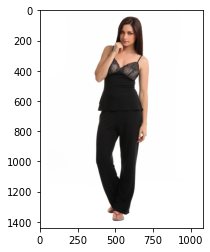

In [88]:
index = np.random.randint(0, len(X_test))                 # Pick a random index from the test set
print(f'Random Index: {index}')

img_id = X_test[index]                                    # Get the image ID
true_label = y_test[index]                                # Get the true one-hot encoded label
true_categories = categories[true_label.astype(bool)].tolist()

img_path = os.path.join(img_dir, f'{img_id}.jpg')         # Get the image path from the ID and img_dir
img = Image.open(img_path)                                # Use Pillow to open the iamge

preprocessed_img = test_transform(img)                    # Preprocess the image using test_transform
preprocessed_img = preprocessed_img.unsqueeze(0)          # Add the required batch dimension (here batchsize=1)

with torch.no_grad():                                     # Without tracking gradients,
    pred = model(preprocessed_img)                        #   Predict the image labels using the model

pred = pred.squeeze()                                     # Remove the batchsize dimension (since batchsize=1)
pred = torch.sigmoid(pred).numpy()                        # Apply a sigmoid function to the model output and convert to numpy datatype
pred = np.round(pred, 0)                                  # Round the predictions to 0 or 1
pred_categories = categories[pred.astype(bool)].tolist()  # Get the category names for the one-hot encoded vector

print(f'Image ID: {img_id}')
print(f'True Labels: {true_categories}')
print(f'Pred Labels: {pred_categories}')
plt.imshow(img);

> **You can also try downloading images from shopping sites like Amazon to see how well the model does.**

['gender_Men', 'masterCategory_Apparel', 'subCategory_Topwear', 'articleType_Tshirts', 'baseColour_Black', 'usage_Sports']


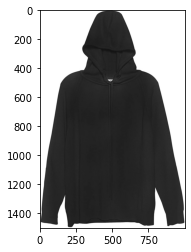

In [92]:
img = Image.open('C:/Users/matth/Documents/fashion_product_dataset/data/amazon_img.jpg')
plt.imshow(img)

preprocessed_img = test_transform(img)
preprocessed_img = preprocessed_img.unsqueeze(0)
model.eval()
with torch.no_grad():
    pred = model(preprocessed_img).squeeze()
pred = torch.sigmoid(pred).numpy()
pred = np.round(pred, 0).astype(bool)
pred_categories = categories[pred]
print(pred_categories.tolist())